In [1]:
import os
from fair import FAIR
from fair.io import read_properties
from fair.interface import initialise
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

/Users/bensan/explore-extensions/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f = FAIR()

In [3]:
snames=["high-extension", "high-overshoot", "medium-extension", "medium-overshoot", "low", "verylow", "verylow-overshoot"]
snames_short=["H-ext","H-ext-OS","M-ext","MOS-ext","L-ext","VL-ext","VLOS-ext"]
sname21_short=["H","H","M","MOS","L","VL","VLOS"]


f.define_time(1750, 2501, 1)
f.define_scenarios(snames)
species, properties = read_properties('../data/fair-parameters/species_configs_properties_1.4.1.csv')
f.define_species(species, properties)
f.ch4_method='Thornhill2021'
df_configs = pd.read_csv('../data/fair-parameters/calibrated_constrained_parameters_1.4.1.csv', index_col=0)
f.define_configs(df_configs.index)
f.allocate()

In [4]:
scens=f.emissions.scenario.values

In [5]:
ldict={}
ldict21={}
for i,s in enumerate(snames):
    ldict[s]=snames_short[i]
    ldict21[s]=sname21_short[i]


In [6]:
colors = {
    snames[0]: '#800000',
    snames[1]: '#ff0000',
    snames[2]: '#c87820',
    snames[3]: '#d3a640',
    snames[4]: '#098740',
    snames[5]: '#0080d0',
    snames[6]: '#100060',
}

In [7]:
os.makedirs('../plots', exist_ok=True)

In [8]:
df_emis = pd.read_csv('../data/emissions/extensions_1750-2500.csv')
gwpmat=df_emis.loc[df_emis.scenario=='verylow-overshoot'].set_index('variable')['ar6_gwp_mass_adjusted']

In [9]:
sdict={}
sdict[scens[0]]=[[2125,2175,2275],[np.NaN,72,0]] # H-ext
sdict[scens[1]]=[[2125,2175,2400,2450],[np.NaN,-34.5,-34.5,0]]# H-ext-OS
#sdict[scens[2]]=[[2125,2200],[np.NaN,0]]# M-ext
sdict[scens[2]]=[[2025,2030,2125,2200],[np.NaN,44,44,0]]# M-ext

sdict[scens[3]]=[[2025,2030,2040,2050,2074,2110,2250,2275],[np.NaN,44,44,10,-3,-17,-17,0]]# MOS-ext
sdict[scens[4]]=[[2025,2030,2040,2050,2075,2105,2180,2200],[np.NaN,40,20,10,0,-5,-5,0]]# L-ext

sdict[scens[5]]=[[2025,2030,2040,2050,2060,2070,2080,2090,2100,2125,2225,2275],[np.NaN,34,15,2,-3,-7,-8.5,-9.3,-9.7,-9.85,-10,0]]# VL-ext

#sdict[scens[6]]=[[2125,2150,2250,2275],[np.NaN,-25,-25,0]]# L-ext-OS
sdict[scens[6]]=[[2025,2030,2073,2100,2150,2250,2275],[np.NaN,44,0,-24,-25,-25,0]]# L-ext-OS




In [10]:
ch4dict={}
ch4dict[scens[0]]=[[2200,2250],[np.NaN,50]] # H-ext
ch4dict[scens[1]]=[[2125,2225],[np.NaN,50]] # H-ext-OS
ch4dict[scens[2]]=[[2300],[np.NaN]]#    M-ext
ch4dict[scens[3]]=[[2040,2050,2060,2080,2090,2100,2125,2300],[np.NaN,200,150,120,100,95,90,90]]#    MOS-ext
ch4dict[scens[4]]=[[2300],[np.NaN]]#    L-ext
ch4dict[scens[5]]=[[2025,2030,2040,2050,2060,2080,2090,2100,2125,2300],[np.NaN,200,150,120,100,95,90,90,90,90]]#    VL-ext
ch4dict[scens[6]]=[[2025,2030,2050,2060,2100,2300],[np.NaN,330,300,170,120,120]]#    L-ext-OS

In [11]:
n2odict={}
n2odict[scens[0]]=[[2200,2250],[np.NaN,6]] # H-ext
n2odict[scens[1]]=[[2125,2225],[np.NaN,6]] # H-ext-OS
n2odict[scens[2]]=[[2300],[np.NaN]] #    M-ext
n2odict[scens[3]]=[[2300],[np.NaN]]     #    MOS-ext
n2odict[scens[4]]=[[2300],[np.NaN]]   #    L-ext
n2odict[scens[5]]=[[2300],[np.NaN]]  #    VL-ext
n2odict[scens[6]]=[[2125,2200],[np.NaN,2]] #    L-ext-OS

In [12]:
f.fill_from_csv(
    emissions_file='../data/emissions/extensions_1750-2500.csv',
    forcing_file='../data/forcing/volcanic_solar.csv',
)

In [13]:

for s in scens:
    corescen=(f.emissions.sel(scenario=s, specie='CO2 FFI',config=1234)+f.emissions.sel(scenario=s, specie='CO2 AFOLU',config=1234)).where(f.emissions.timepoints<=sdict[s][0][0], drop=True)
    corelu=f.emissions.sel(scenario=s, specie='CO2 AFOLU',config=1234)
    histtim=f.emissions.timepoints.where(f.emissions.timepoints<=sdict[s][0][0], drop=True)
    tmpf=f.emissions.sel(scenario=s, specie='CO2 FFI',config=1234).copy()
    tmpf[:]=(f.emissions.timepoints,np.interp(f.emissions.timepoints,np.hstack([histtim,sdict[s][0][1:]]),np.hstack([corescen,sdict[s][1][1:]])))[1]
    
    f.emissions.sel(scenario=s, specie='CO2 FFI').loc[:,:]=tmpf-corelu
for s in scens:
    corescen=f.emissions.sel(scenario=s, specie='CH4',config=1234).where(f.emissions.timepoints<=ch4dict[s][0][0], drop=True)
    histtim=f.emissions.timepoints.where(f.emissions.timepoints<=ch4dict[s][0][0], drop=True)
    tmpf=f.emissions.sel(scenario=s, specie='CH4',config=1234).copy()
    tmpf[:]=(f.emissions.timepoints,np.interp(f.emissions.timepoints,np.hstack([histtim,ch4dict[s][0][1:]]),np.hstack([corescen,ch4dict[s][1][1:]])))[1]
    f.emissions.sel(scenario=s, specie='CH4').loc[:,:]=tmpf
for s in scens:
    corescen=f.emissions.sel(scenario=s, specie='N2O',config=1234).where(f.emissions.timepoints<=n2odict[s][0][0], drop=True)
    histtim=f.emissions.timepoints.where(f.emissions.timepoints<=n2odict[s][0][0], drop=True)
    tmpf=f.emissions.sel(scenario=s, specie='N2O',config=1234).copy()
    tmpf[:]=(f.emissions.timepoints,np.interp(f.emissions.timepoints,np.hstack([histtim,n2odict[s][0][1:]]),np.hstack([corescen,n2odict[s][1][1:]])))[1]
    f.emissions.sel(scenario=s, specie='N2O').loc[:,:]=tmpf

blending for 4 years, starting with 2022

In [14]:
cyrs=4
cfx=2022.5
bstrt=f.emissions.sel(timepoints=cfx).copy()

for i in np.arange(0,cyrs):
    yr=cfx+i
    f.emissions.loc[dict(timepoints=yr)]=bstrt

byrs=5
bfx=2025.5
for i in np.arange(0,byrs):
    yr=bfx+i
    e_org=f.emissions.loc[dict(timepoints=yr)].copy()
    f.emissions.loc[dict(timepoints=yr)]=bstrt*(1-i/byrs)+e_org*(i/byrs)



(2000.0, 2125.0)

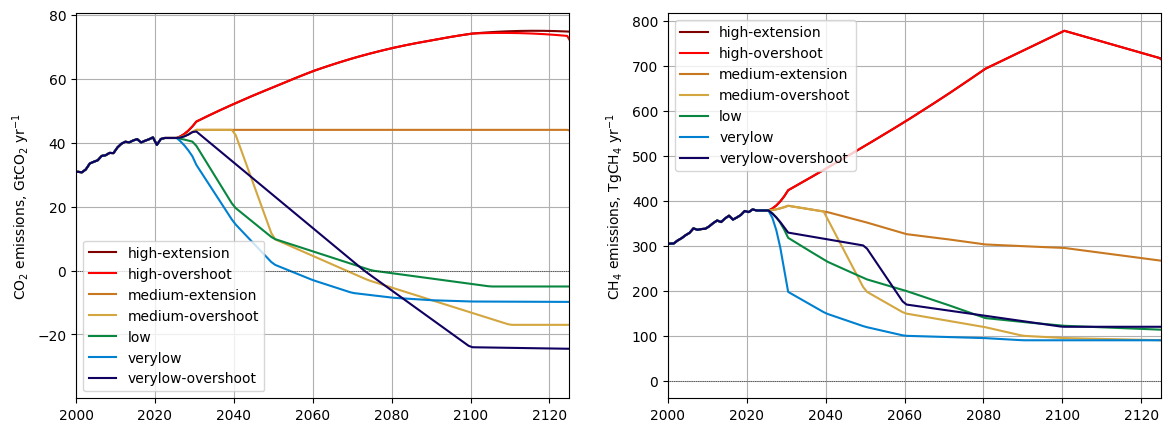

In [15]:
fig, ax = pl.subplots(nrows=1,ncols=2,figsize=(14,5))
for scenario in f.scenarios:
    ax[0].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ),
        label=scenario,
        color=colors[scenario]
    )
ax[0].set_ylabel("CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[0].axhline(ls=':', color='k', lw=0.5)
ax[0].legend()
ax[0].grid()
ax[0].set_xlim(2000,2125)
for scenario in f.scenarios:
    ax[1].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CH4", config=f.configs[0]) 
        ),
        label=scenario,
        color=colors[scenario]
    )
ax[1].set_ylabel("CH$_4$ emissions, TgCH$_4$ yr$^{-1}$")
ax[1].axhline(ls=':', color='k', lw=0.5)
ax[1].legend()
ax[1].grid()
ax[1].set_xlim(2000,2125)



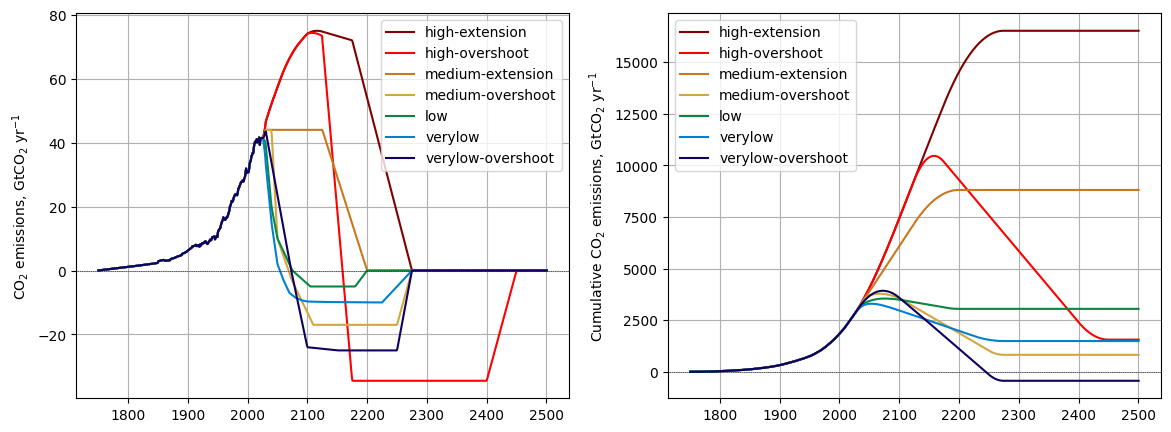

In [16]:
fig, ax = pl.subplots(nrows=1,ncols=2,figsize=(14,5))
for scenario in f.scenarios:
    ax[0].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ),
        label=scenario,
        color=colors[scenario]
    )
ax[0].set_ylabel("CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[0].axhline(ls=':', color='k', lw=0.5)
ax[0].legend()
ax[0].grid()
for scenario in f.scenarios:
    ax[1].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ).cumsum(),
        label=scenario,
        color=colors[scenario]
    )
ax[1].set_ylabel("Cumulative CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[1].axhline(ls=':', color='k', lw=0.5)
ax[1].legend()
ax[1].grid()
pl.savefig('../plots/co2_emissions.png')

Calculate CO2e

In [17]:
co2eo=f.emissions.sel(specie='CO2 FFI')[:,:,0].copy()
for specie in f.emissions.specie.values:
   try: 
     gwp=gwpmat[specie]
   except:
     gwp=np.NaN
   if ~np.isnan(gwp):
      co2eo=co2eo+f.emissions.sel(specie=specie)[:,:,0]*gwp
   else:
      0  


Bias correct co2e

In [18]:
gwpmat

variable
BC                    NaN
C2F6             12400.00
C3F8              9290.00
C4F10            10000.00
C5F12             9220.00
C6F14             8620.00
C7F16             8410.00
C8F18             8260.00
CCl4              2200.00
CF4               7380.00
CFC-11            6230.00
CFC-113           6520.00
CFC-114           9430.00
CFC-115           9600.00
CFC-12           12500.00
CH2Cl2              11.20
CH3Br                2.43
CH3CCl3            161.00
CH3Cl                5.54
CH4              27900.00
CHCl3               20.60
CO                    NaN
CO2 AFOLU      1000000.00
CO2 FFI        1000000.00
HCFC-141b          860.00
HCFC-142b         2300.00
HCFC-22           1960.00
HFC-125           3740.00
HFC-134a          1530.00
HFC-143a          5810.00
HFC-152a           164.00
HFC-227ea         3600.00
HFC-23           14600.00
HFC-236fa         8690.00
HFC-245fa          962.00
HFC-32             771.00
HFC-365mfc         914.00
HFC-4310mee       1600.00
Hal

In [19]:
co2e=co2eo-co2eo.loc[dict(timepoints=2019.5)].values+53.e6

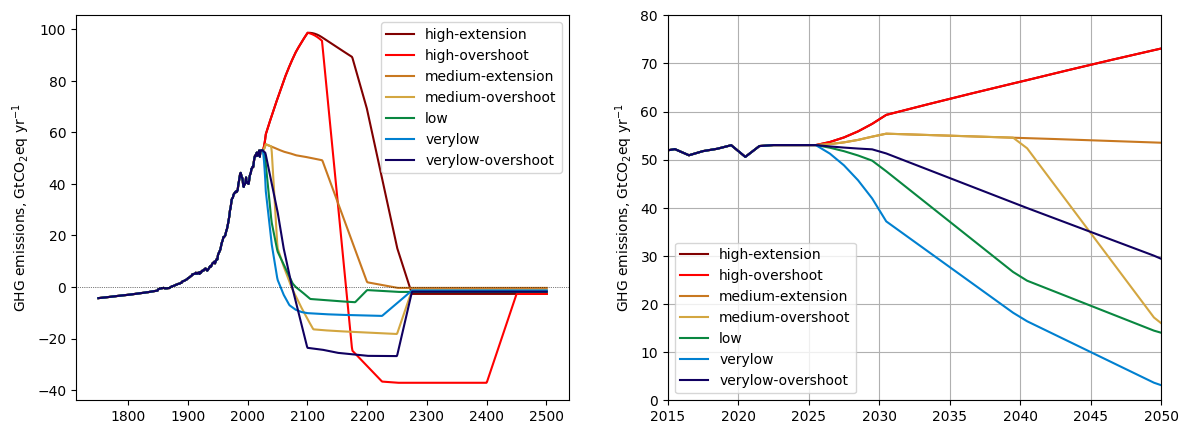

In [20]:
fig, ax = pl.subplots(1,2,figsize=(14,5))
for scenario in f.scenarios:
    ax[0].plot(
        f.timepoints,
        co2e.sel(scenario=scenario)/ 1e6,
        label=scenario,
        color=colors[scenario]
    )
ax[0].set_ylabel("GHG emissions, GtCO$_2$eq yr$^{-1}$")
ax[0].axhline(ls=':', color='k', lw=0.5)
ax[0].legend();

for scenario in f.scenarios:
    ax[1].plot(
        f.timepoints,
        co2e.sel(scenario=scenario)/ 1e6,
        label=scenario,
        color=colors[scenario]
    )
ax[1].set_ylabel("GHG emissions, GtCO$_2$eq yr$^{-1}$")
ax[1].axhline(ls=':', color='k', lw=0.5)
ax[1].legend()
ax[1].set_xlim(2015,2050)
ax[1].set_ylim(0,80)

ax[1].grid()
pl.savefig('../plots/ghg_emissions.png')

In [21]:
f.fill_species_configs('../data/fair-parameters/species_configs_properties_1.4.1.csv')
f.override_defaults('../data/fair-parameters/calibrated_constrained_parameters_1.4.1.csv')
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)
initialise(f.ocean_heat_content_change, 0)
f.run()

Running 5887 projections in parallel: 100%|██████████| 751/751 [00:41<00:00, 18.16timesteps/s]


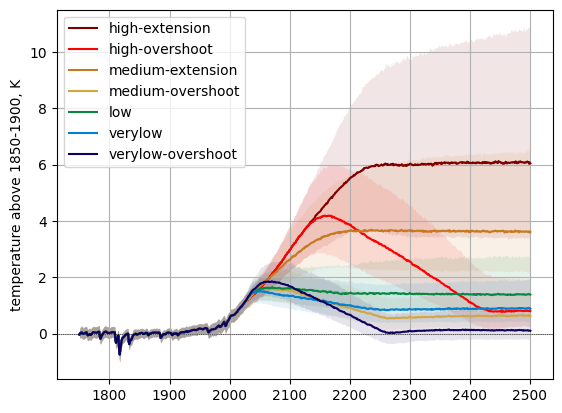

In [22]:
fig, ax = pl.subplots()
for scenario in f.scenarios:
    ax.fill_between(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.05, dim='config'),
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        lw=0,
        alpha=0.1
    )
    ax.plot(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax.axhline(0, ls=':', color='k', lw=0.5)
ax.set_ylabel('temperature above 1850-1900, K')
ax.ylim=(-0.5, 6.5)
ax.grid()
pl.legend();
pl.savefig('../plots/temperature.png')

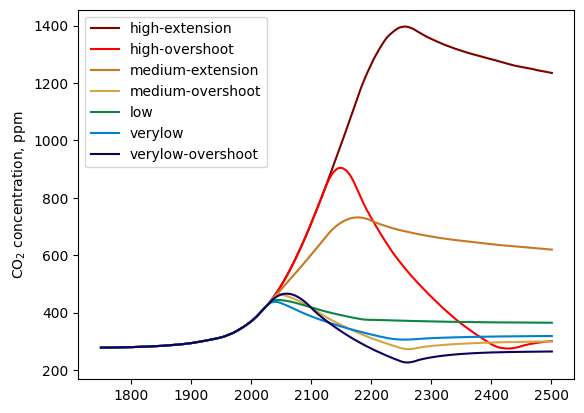

In [23]:
fig, ax = pl.subplots()
for scenario in f.scenarios:
    ax.plot(
        f.timebounds,
        f.concentration.sel(scenario=scenario, specie="CO2").median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax.set_ylabel('CO$_2$ concentration, ppm')
pl.legend();
pl.savefig('../plots/co2_concentration.png')

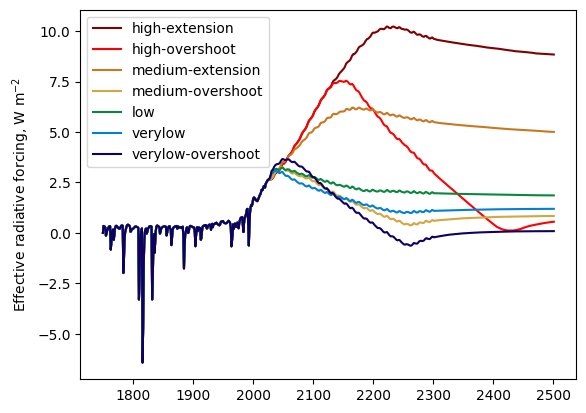

In [24]:
fig, ax = pl.subplots()
for scenario in f.scenarios:
    pl.plot(
        f.timebounds,
        f.forcing_sum.sel(scenario=scenario).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax.set_ylabel('Effective radiative forcing, W m$^{-2}$')
pl.legend();
pl.savefig('../plots/forcing.png')

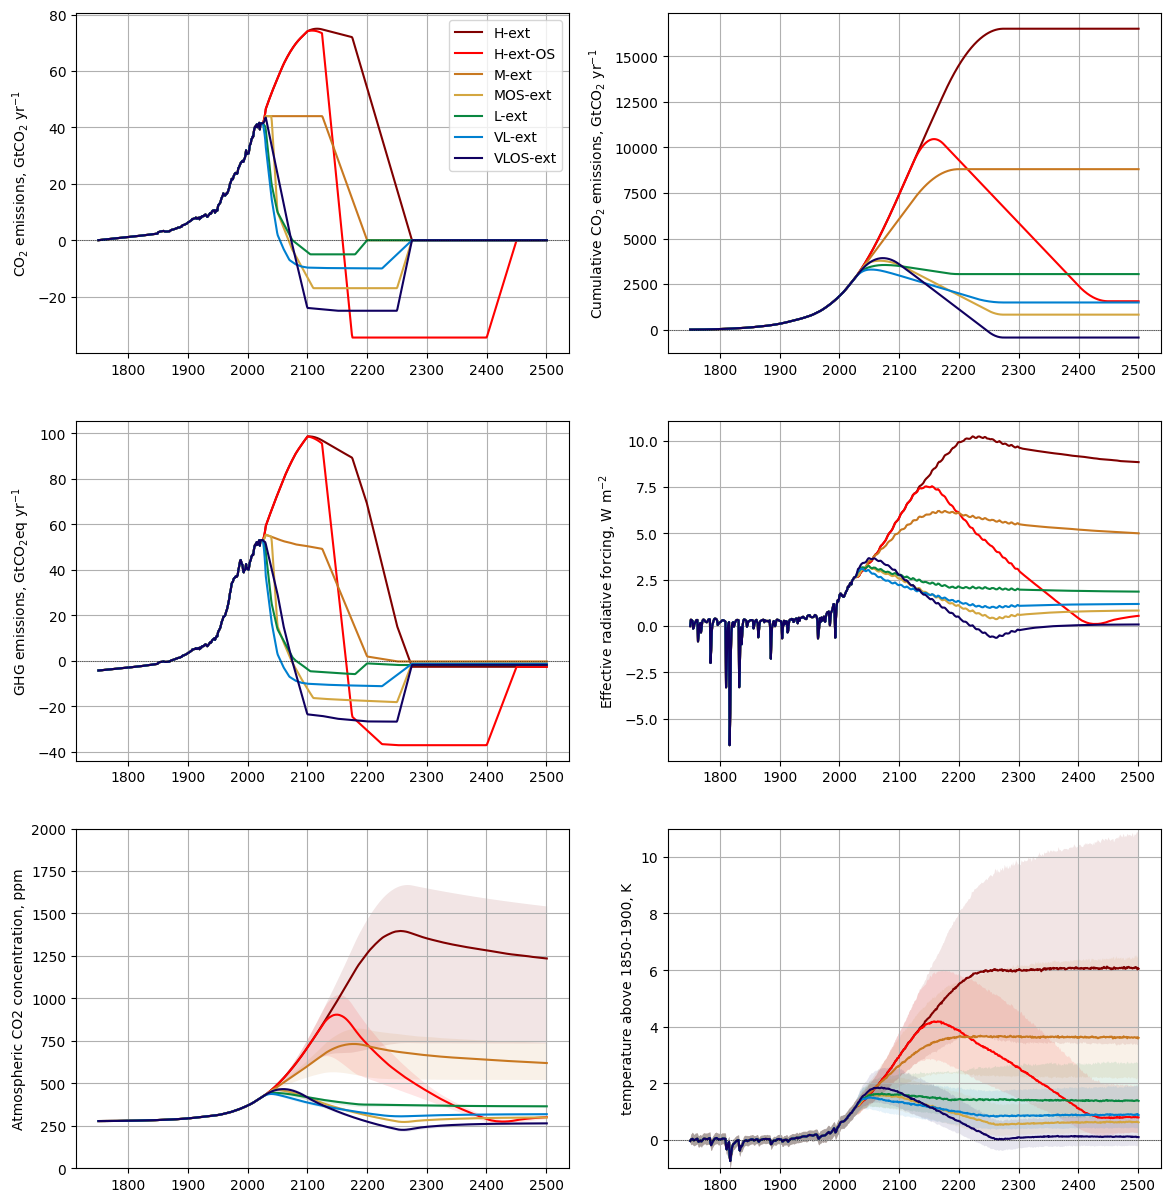

In [25]:
fig, ax = pl.subplots(nrows=3,ncols=2,figsize=(14,15))
ax=ax.flatten()
for scenario in f.scenarios:
    ax[0].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ),
        label=ldict[scenario],
        color=colors[scenario]
    )
ax[0].set_ylabel("CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[0].axhline(ls=':', color='k', lw=0.5)
ax[0].legend()
ax[0].grid()
for scenario in f.scenarios:
    ax[1].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ).cumsum(),
        label=scenario,
        color=colors[scenario]
    )
ax[1].set_ylabel("Cumulative CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[1].axhline(ls=':', color='k', lw=0.5)
#ax[1].legend()
ax[1].grid()

for scenario in f.scenarios:
    ax[2].plot(
        f.timepoints,
        co2e.sel(scenario=scenario)/ 1e6,
        label=scenario,
        color=colors[scenario]
    )
ax[2].set_ylabel("GHG emissions, GtCO$_2$eq yr$^{-1}$")
ax[2].axhline(ls=':', color='k', lw=0.5)
#ax[2].legend()
ax[2].grid()

for scenario in f.scenarios:
    ax[3].plot(
        f.timebounds,
        f.forcing_sum.sel(scenario=scenario).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax[3].set_ylabel('Effective radiative forcing, W m$^{-2}$')
#pl.legend();
ax[3].grid()

for scenario in f.scenarios:
    ax[4].fill_between(
        f.timebounds,
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario, )
        ).quantile(0.05, dim='config'),
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario)
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        lw=0,
        alpha=0.1
    )
    ax[4].plot(
        f.timebounds,
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario)
        ).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax[4].axhline(0, ls=':', color='k', lw=0.5)
ax[4].set_ylabel('Atmospheric CO2 concentration, ppm')
ax[4].set_ylim(0,2000)
ax[4].grid()
for scenario in f.scenarios:
    ax[5].fill_between(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.05, dim='config'),
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        lw=0,
        alpha=0.1
    )
    ax[5].plot(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax[5].axhline(0, ls=':', color='k', lw=0.5)
ax[5].set_ylabel('temperature above 1850-1900, K')
ax[5].set_ylim(-1, 11)
ax[5].grid()

pl.savefig('../plots/extensions.png')

In [27]:
f21c=[ f.scenarios[x] for x in [0,2,3,4,5,6]]

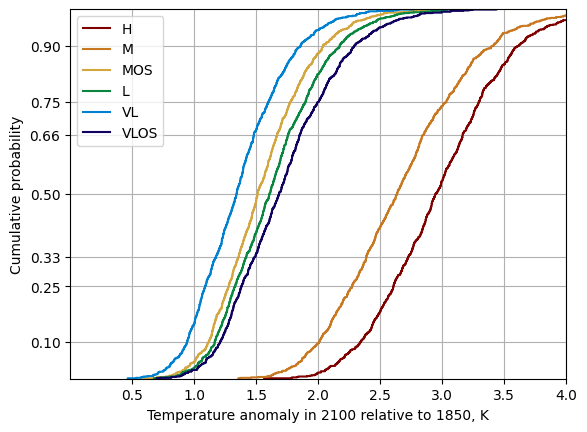

In [50]:
for scenario in f21c:
    a=pl.ecdf(f.temperature.sel(scenario=scenario, layer=0, timebounds=2100)-f.temperature.sel(scenario=scenario, layer=0, timebounds=1850),color=colors[scenario],label=ldict21[scenario])
pl.xlabel('Temperature anomaly in 2100 relative to 1850, K')
pl.ylabel('Cumulative probability')
pl.yticks([0.1,0.25,0.33,0.5,0.66,0.75,0.9])
pl.xticks([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
pl.xlim([0,4])
pl.legend()
pl.grid()

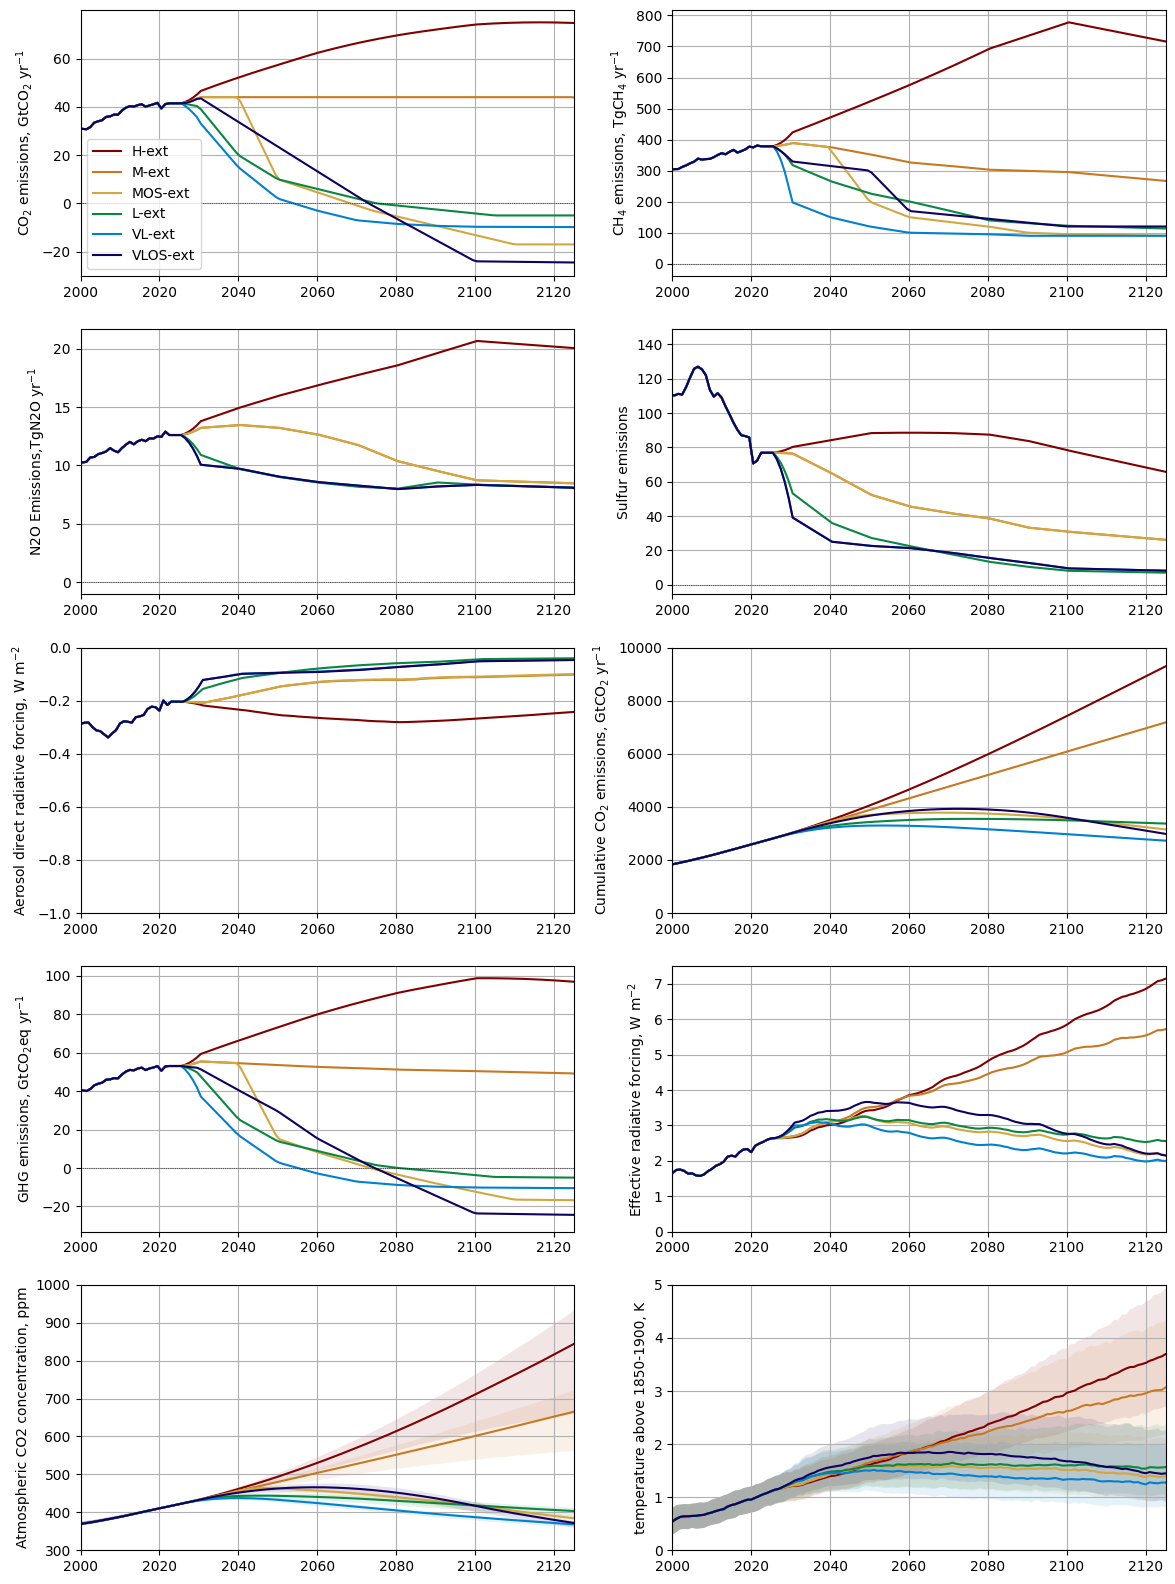

In [38]:
fig, ax = pl.subplots(nrows=5,ncols=2,figsize=(14,20))
ax=ax.flatten()
for scenario in f21c:
    ax[0].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ),
        label=ldict[scenario],
        color=colors[scenario]
    )
ax[0].set_ylabel("CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[0].axhline(ls=':', color='k', lw=0.5)
ax[0].legend()
ax[0].grid()
ax[0].set_xlim(2000, 2125)

for scenario in f21c:
    ax[1].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CH4", config=f.configs[0]) 
        ),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[1].set_ylabel("CH$_4$ emissions, TgCH$_4$ yr$^{-1}$")
ax[1].axhline(ls=':', color='k', lw=0.5)

ax[1].grid()
ax[1].set_xlim(2000, 2125)

for scenario in f21c:
    ax[2].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="N2O", config=f.configs[0]) 
        ),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[2].set_ylabel("N2O Emissions,TgN2O yr$^{-1}$")
ax[2].axhline(ls=':', color='k', lw=0.5)
#ax[2].legend()
ax[2].grid()
ax[2].set_xlim(2000, 2125)


for scenario in f21c:
    ax[3].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="Sulfur", config=f.configs[0]) 
        ),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[3].set_ylabel("Sulfur emissions",)
ax[3].axhline(ls=':', color='k', lw=0.5)
#ax[2].legend()
ax[3].grid()
ax[3].set_xlim(2000, 2125)

for scenario in f21c:
    ax[4].plot(
        f.timebounds,
        f.forcing.sel(scenario=scenario,specie='Aerosol-radiation interactions').median(dim='config'),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[4].set_ylabel('Aerosol direct radiative forcing, W m$^{-2}$')
#pl.legend();
ax[4].grid()
ax[4].set_xlim(2000, 2125)
ax[4].set_ylim(-1, 0)




for scenario in f21c:
    ax[5].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ).cumsum(),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[5].set_ylabel("Cumulative CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[5].axhline(ls=':', color='k', lw=0.5)
#ax[1].legend()
ax[5].grid()
ax[5].set_xlim(2000, 2125)
ax[5].set_ylim(0, 10000)

for scenario in f21c:
    ax[6].plot(
        f.timepoints,
        co2e.sel(scenario=scenario)/ 1e6,
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[6].set_ylabel("GHG emissions, GtCO$_2$eq yr$^{-1}$")
ax[6].axhline(ls=':', color='k', lw=0.5)
#ax[2].legend()
ax[6].grid()
ax[6].set_xlim(2000, 2125)


for scenario in f21c:
    ax[7].plot(
        f.timebounds,
        f.forcing_sum.sel(scenario=scenario).median(dim='config'),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[7].set_ylabel('Effective radiative forcing, W m$^{-2}$')
#pl.legend();
ax[7].grid()
ax[7].set_xlim(2000, 2125)
ax[7].set_ylim(0, 7.5)

for scenario in f21c:
    ax[8].fill_between(
        f.timebounds,
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario, )
        ).quantile(0.05, dim='config'),
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario)
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        lw=0,
        alpha=0.1
    )
    ax[8].plot(
        f.timebounds,
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario)
        ).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax[8].axhline(0, ls=':', color='k', lw=0.5)
ax[8].set_ylabel('Atmospheric CO2 concentration, ppm')
ax[8].set_ylim(0,2000)
ax[8].grid()
ax[8].set_xlim(2000, 2125)
ax[8].set_ylim(300, 1000)
for scenario in f21c:
    ax[9].fill_between(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.05, dim='config'),
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        lw=0,
        alpha=0.1
    )
    ax[9].plot(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax[9].axhline(0, ls=':', color='k', lw=0.5)
ax[9].set_ylabel('temperature above 1850-1900, K')
ax[9].set_ylim(-1, 11)
ax[9].grid()
ax[9].set_xlim(2000, 2125)
ax[9].set_ylim(0, 5)


pl.savefig('../plots/extensions.png')